In [12]:
!pip install -q kaggle pandas opencv-python


!mkdir -p /content/DermAI/data/raw
!mkdir -p /content/DermAI/data/processed
!cd /content/DermAI

In [13]:
from google.colab import files
import os, json, stat
uploaded = files.upload()
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json','wb') as f:
        f.write(uploaded['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', stat.S_IRUSR | stat.S_IWUSR)
    print("kaggle.json uploaded")
else:
    print("kaggle.json not found.")


Saving kaggle.json to kaggle.json
kaggle.json uploaded


In [14]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/DermAI/data/raw --unzip

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:26<00:00, 138MB/s]
100% 5.20G/5.20G [01:26<00:00, 64.9MB/s]


In [15]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil

RAW_DIR = '/content/DermAI/data/raw'
OUT_META = '/content/DermAI/data/metadata.csv'
# Fix: Images are in two subdirectories after unzip
IMG_PART_1_DIR = os.path.join(RAW_DIR, 'ham10000_images_part_1')
IMG_PART_2_DIR = os.path.join(RAW_DIR, 'ham10000_images_part_2')

meta_paths = [p for p in os.listdir(RAW_DIR) if p.lower().endswith('.csv')]
print("CSV files in raw dir:", meta_paths)
assert len(meta_paths) > 0, "No CSV metadata found in data/raw — check your unzip/upload step."

# Find the correct metadata CSV file
metadata_filename = None
for p in meta_paths:
    if 'ham10000_metadata' in p.lower():
        metadata_filename = p
        break

assert metadata_filename is not None, "HAM10000_metadata.csv not found."

meta_csv = os.path.join(RAW_DIR, metadata_filename)
df = pd.read_csv(meta_csv)
print("Loaded metadata shape:", df.shape)
display(df.head())

#mapping dx which is diagnosis to integer labels
dx_to_label = {'akiec':0, 'bcc':1, 'bkl':2, 'df':3, 'nv':4, 'mel':5, 'vasc':6}
df = df[['image_id','dx']].rename(columns={'dx':'label'})

#it keeps only rows whose label is valid and then resets indexing.
df = df[df['label'].isin(dx_to_label.keys())].reset_index(drop=True)
df['label'] = df['label'].map(dx_to_label)

#check files exist in either part 1 or part 2 directories
missing = []
for img_id in df['image_id'].tolist():
    fn1 = os.path.join(IMG_PART_1_DIR, img_id + '.jpg')
    fn2 = os.path.join(IMG_PART_2_DIR, img_id + '.jpg')
    if not os.path.exists(fn1) and not os.path.exists(fn2):
        missing.append(img_id)
print(f"Missing images: {len(missing)} (should be 0 if unzip succeeded).")
if len(missing)>0:
    print("Example missing IDs:", missing[:10])

#traintest split (stratified)
train_val, test = train_test_split(df, test_size=0.10, stratify=df['label'], random_state=42)
train, val = train_test_split(train_val, test_size= (0.10/0.90), stratify=train_val['label'], random_state=42)

print("Counts per split:")
print("train:", train['label'].value_counts().sort_index().to_dict())
print("val:", val['label'].value_counts().sort_index().to_dict())
print("test:", test['label'].value_counts().sort_index().to_dict())

#combine and save metadata.csv with a split column
meta_all = pd.concat([
    train.assign(split='train'),
    val.assign(split='val'),
    test.assign(split='test')
]).reset_index(drop=True)

meta_all.to_csv(OUT_META, index=False)
print("Saved metadata to", OUT_META)
meta_all.head()

CSV files in raw dir: ['hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv']
Loaded metadata shape: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Missing images: 0 (should be 0 if unzip succeeded).
Counts per split:
train: {0: 261, 1: 411, 2: 879, 3: 92, 4: 5363, 5: 891, 6: 114}
val: {0: 33, 1: 52, 2: 110, 3: 11, 4: 671, 5: 111, 6: 14}
test: {0: 33, 1: 51, 2: 110, 3: 12, 4: 671, 5: 111, 6: 14}
Saved metadata to /content/DermAI/data/metadata.csv


,image_id,label,split
0,ISIC_0030786,4,train
1,ISIC_0027091,4,train
2,ISIC_0028634,4,train
3,ISIC_0030336,4,train
4,ISIC_0030896,4,train


In [16]:
import os

IMG_PART_1_DIR = "/content/DermAI/data/raw/HAM10000_images_part_1"
IMG_PART_2_DIR = "/content/DermAI/data/raw/HAM10000_images_part_2"

print("Part 1 exists:", os.path.exists(IMG_PART_1_DIR))
print("Part 2 exists:", os.path.exists(IMG_PART_2_DIR))


Part 1 exists: True
Part 2 exists: True


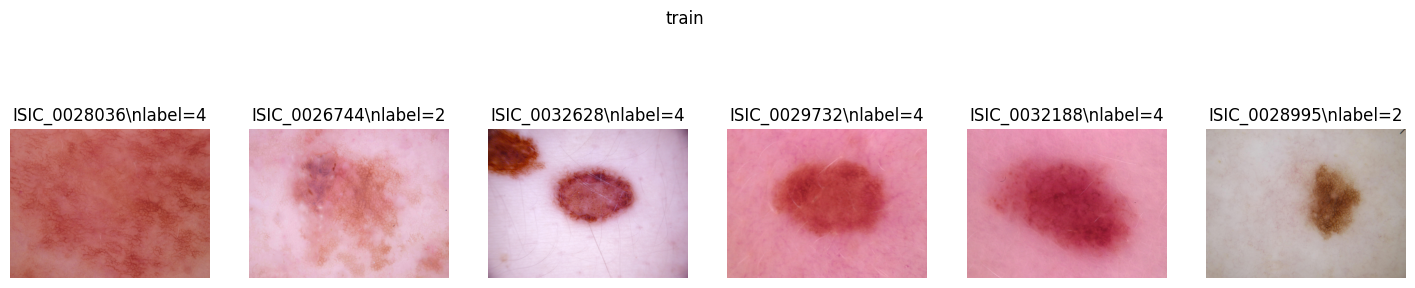

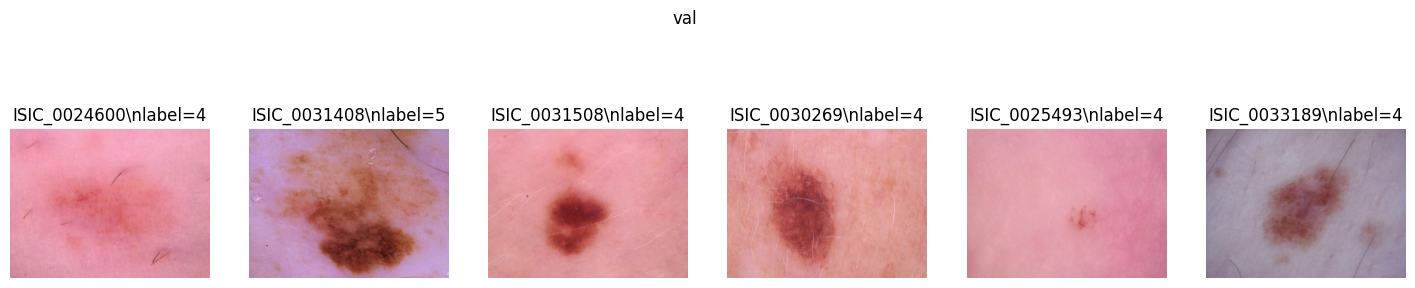

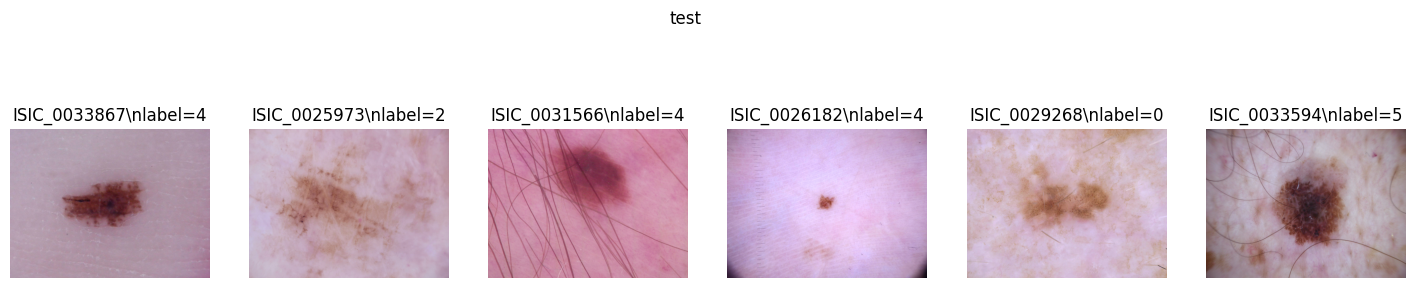

split
train    8011
val      1002
test     1002
Name: count, dtype: int64
Class distribution overall:
label
0     327
1     514
2    1099
3     115
4    6705
5    1113
6     142
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt
import cv2
import random
meta = pd.read_csv('/content/DermAI/data/metadata.csv')

def show_samples(split, n=6):
    s = meta[meta['split']==split].sample(n)
    fig, axs = plt.subplots(1, n, figsize=(3*n,4))
    for ax, (_, row) in zip(axs, s.iterrows()):
        # Try finding in part 1
        img_path = os.path.join(IMG_PART_1_DIR, row['image_id'] + '.jpg')
        if not os.path.exists(img_path):
            # If not in part 1, try part 2
            img_path = os.path.join(IMG_PART_2_DIR, row['image_id'] + '.jpg')

        img = cv2.imread(img_path)
        # Check if img is successfully loaded before converting color
        if img is None:
            print(f"Could not load image: {img_path}.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"{row['image_id']}\\nlabel={row['label']}")
        ax.axis('off')
    plt.suptitle(split)
    plt.show()

show_samples('train', n=6)
show_samples('val', n=6)
show_samples('test', n=6)

#show counts
print(meta['split'].value_counts())
print("Class distribution overall:")
print(meta['label'].value_counts().sort_index())

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import cv2
import os

IMG_PART_1_DIR = "/content/DermAI/data/raw/HAM10000_images_part_1"
IMG_PART_2_DIR = "/content/DermAI/data/raw/HAM10000_images_part_2"
META_PATH = "/content/DermAI/data/metadata.csv"


In [19]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [20]:
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row["image_id"]

        # try part 1
        img_path = os.path.join(IMG_PART_1_DIR, image_id + ".jpg")
        if not os.path.exists(img_path):
            # fallback to part 2
            img_path = os.path.join(IMG_PART_2_DIR, image_id + ".jpg")

        # load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # apply transforms
        if self.transform:
            img = self.transform(img)

        label = int(row["label"])

        return img, label


In [21]:
meta = pd.read_csv(META_PATH)

train_df = meta[meta["split"] == "train"].reset_index(drop=True)
val_df   = meta[meta["split"] == "val"].reset_index(drop=True)
test_df  = meta[meta["split"] == "test"].reset_index(drop=True)

train_dataset = SkinDataset(train_df, transform=train_transforms)
val_dataset   = SkinDataset(val_df,   transform=val_transforms)
test_dataset  = SkinDataset(test_df,  transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset), len(test_dataset)


(8011, 1002, 1002)

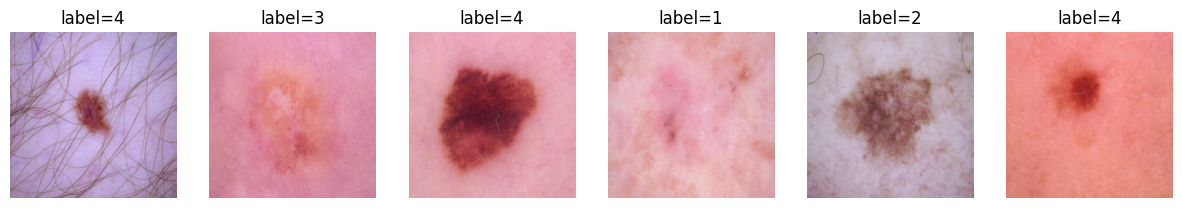

In [22]:
import matplotlib.pyplot as plt

def show_batch(loader):
    imgs, labels = next(iter(loader))
    imgs = imgs[:6]

    fig, axs = plt.subplots(1, 6, figsize=(15, 4))
    for ax, img, label in zip(axs, imgs, labels):
        img_np = img.permute(1,2,0).cpu().numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = img_np.clip(0,1)

        ax.imshow(img_np)
        ax.set_title(f"label={label.item()}")
        ax.axis("off")

    plt.show()

show_batch(train_loader)


Model Building


In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2  # Colab is fine with 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

len(train_loader), len(val_loader), len(test_loader)

(251, 32, 32)

In [24]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [25]:
!pip install timm


In [26]:
import timm
import torch.nn as nn
import torch
import pandas as pd
import os
META_PATH = "/content/DermAI/data/metadata.csv"

#check if metadata file exists before attempting to read it
if not os.path.exists(META_PATH):
    raise FileNotFoundError(f"Metadata file not found at {META_PATH}. Please ensure the data preparation cell (ba4FNvpWem7K) has been run successfully to create this file.")

if 'meta' not in locals():
    meta = pd.read_csv(META_PATH)

NUM_CLASSES = meta['label'].nunique()

model = timm.create_model(
    'efficientnet_b3',
    pretrained=True,
    num_classes=NUM_CLASSES
)

model = model.to('cuda')
model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [29]:
#freezing first few layers
for name, param in model.named_parameters():
    if name.startswith("blocks.0") or name.startswith("blocks.1"):
        param.requires_grad = False


In [30]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

trainable, total


(10655369, 10706991)

In [31]:
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

#checkpoint dir
CHECKPOINT_DIR = "/content/DermAI/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [32]:
labels = pd.read_csv(META_PATH)['label'].values
classes, counts = np.unique(labels, return_counts=True)
print("Counts per class:", dict(zip(classes, counts)))

#inverse frequency weighting
class_weights = counts.sum() / (len(classes) * counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

lr = 1e-4
weight_decay = 1e-6
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

epochs = 12
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)


Counts per class: {np.int64(0): np.int64(327), np.int64(1): np.int64(514), np.int64(2): np.int64(1099), np.int64(3): np.int64(115), np.int64(4): np.int64(6705), np.int64(5): np.int64(1113), np.int64(6): np.int64(142)}
Class weights: tensor([ 4.3753,  2.7835,  1.3018, 12.4410,  0.2134,  1.2855, 10.0755],
       device='cuda:0')


In [33]:
from collections import defaultdict

scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    losses = []
    preds_all = []
    targs_all = []
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        losses.append(loss.item() * imgs.size(0))
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        preds_all.extend(preds.tolist())
        targs_all.extend(labels.detach().cpu().numpy().tolist())
        pbar.set_postfix(loss=loss.item())

    epoch_loss = sum(losses) / len(loader.dataset)
    epoch_acc = accuracy_score(targs_all, preds_all)
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    losses = []
    preds_all = []
    targs_all = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Valid", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(imgs)
            loss = criterion(logits, labels)

            losses.append(loss.item() * imgs.size(0))
            preds = logits.argmax(dim=1).detach().cpu().numpy()
            preds_all.extend(preds.tolist())
            targs_all.extend(labels.detach().cpu().numpy().tolist())

    epoch_loss = sum(losses) / len(loader.dataset)
    epoch_acc = accuracy_score(targs_all, preds_all)
    return epoch_loss, epoch_acc

best_val_acc = 0.0
history = defaultdict(list)

for epoch in range(1, epochs+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs}  time:{time.time()-t0:.0f}s  train_loss:{train_loss:.4f} train_acc:{train_acc:.4f}  val_loss:{val_loss:.4f} val_acc:{val_acc:.4f}")


    ckpt = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'val_acc': val_acc,
        'history': history
    }
    torch.save(ckpt, os.path.join(CHECKPOINT_DIR, f"epoch_{epoch}.pth"))

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ckpt, os.path.join(CHECKPOINT_DIR, "best.pth"))
        print(" -> Saved best.pth")


/tmp/ipython-input-3451142688.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None
Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01/12  time:110s  train_loss:1.8191 train_acc:0.4664  val_loss:1.2431 val_acc:0.6148
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 02/12  time:83s  train_loss:0.7005 train_acc:0.7114  val_loss:0.9211 val_acc:0.6826
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 03/12  time:81s  train_loss:0.4277 train_acc:0.7953  val_loss:0.9121 val_acc:0.7236
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 04/12  time:82s  train_loss:0.2875 train_acc:0.8558  val_loss:0.9587 val_acc:0.7405
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 05/12  time:82s  train_loss:0.2048 train_acc:0.8863  val_loss:0.9103 val_acc:0.7565
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 06/12  time:82s  train_loss:0.1442 train_acc:0.9142  val_loss:0.9390 val_acc:0.7844
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 07/12  time:81s  train_loss:0.1217 train_acc:0.9306  val_loss:0.8733 val_acc:0.7894
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 08/12  time:82s  train_loss:0.0933 train_acc:0.9482  val_loss:1.0052 val_acc:0.7984
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 09/12  time:82s  train_loss:0.0662 train_acc:0.9558  val_loss:1.0047 val_acc:0.8074
 -> Saved best.pth


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/12  time:82s  train_loss:0.0646 train_acc:0.9613  val_loss:1.0027 val_acc:0.8054


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/12  time:82s  train_loss:0.0520 train_acc:0.9683  val_loss:0.9384 val_acc:0.8054


Train:   0%|          | 0/251 [00:00<?, ?it/s]/tmp/ipython-input-3451142688.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/12  time:82s  train_loss:0.0534 train_acc:0.9672  val_loss:0.9548 val_acc:0.8004


In [35]:
ckpt_path = os.path.join(CHECKPOINT_DIR, "best.pth")
if os.path.exists(ckpt_path):
    print("Loading checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model'])
else:
    print("No best checkpoint found, using current model in memory.")

test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")

Loading checkpoint: /content/DermAI/checkpoints/best.pth


Test Loss: 0.9272  Test Acc: 0.8204


In [37]:
import torch, os, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

CHECKPOINT_DIR = "/content/DermAI/checkpoints"
best_ckpt = os.path.join(CHECKPOINT_DIR, "best.pth")
assert os.path.exists(best_ckpt), f"Best checkpoint not found at {best_ckpt}"
ckpt = torch.load(best_ckpt, map_location=device, weights_only=False)

import timm
NUM_CLASSES = meta['label'].nunique()
model = timm.create_model('efficientnet_b3', pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(ckpt['model'])
model = model.to(device)
model.eval()
print("Loaded model from", best_ckpt)

Device: cuda
Loaded model from /content/DermAI/checkpoints/best.pth


In [39]:
from tqdm import tqdm
import os
all_probs = []
all_preds = []
all_labels = []
all_image_ids = []


test_df = meta[meta['split']=='test'].reset_index(drop=True)

from torch.utils.data import DataLoader

test_dataset = SkinDataset(test_df, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Infer"):
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = softmax(logits).cpu().numpy()
        preds = probs.argmax(axis=1).tolist()
        all_probs.extend(probs.tolist())
        all_preds.extend(preds)
        all_labels.extend(labels.numpy().tolist())

#dataFrame for predictions
pred_df = pd.DataFrame({
    "image_id": test_df['image_id'].values,
    "true_label": all_labels,
    "pred_label": all_preds
})
#append probability columns
prob_cols = [f"p_{i}" for i in range(NUM_CLASSES)]
probs_arr = np.array(all_probs)
for i, c in enumerate(prob_cols):
    pred_df[c] = probs_arr[:, i]

pred_csv = "/content/DermAI/results/test_predictions.csv"
# Create the directory if it does not exist
os.makedirs(os.path.dirname(pred_csv), exist_ok=True)
pred_df.to_csv(pred_csv, index=False)
print("Saved predictions to", pred_csv)

Infer: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]

Saved predictions to /content/DermAI/results/test_predictions.csv


Classification report:
              precision    recall  f1-score   support

           0     0.6176    0.6364    0.6269        33
           1     0.7091    0.7647    0.7358        51
           2     0.6500    0.5909    0.6190       110
           3     0.6000    0.7500    0.6667        12
           4     0.9290    0.8972    0.9128       671
           5     0.5368    0.6577    0.5911       111
           6     0.9286    0.9286    0.9286        14

    accuracy                         0.8204      1002
   macro avg     0.7102    0.7465    0.7258      1002
weighted avg     0.8295    0.8204    0.8238      1002



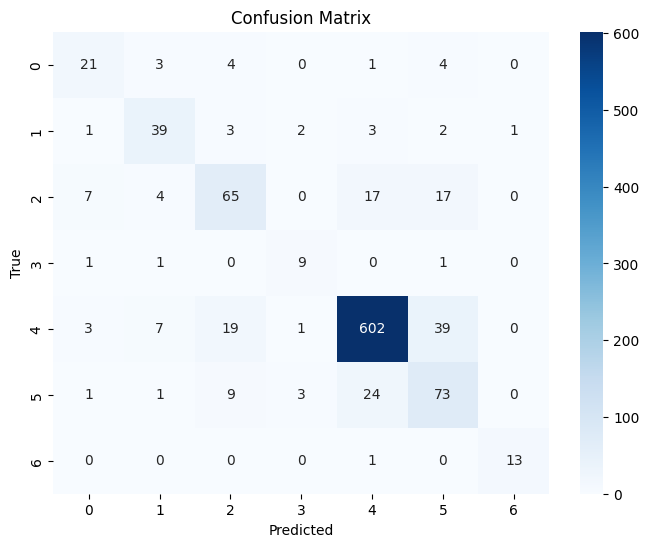

ROC-AUC (ovr): 0.9608695228880099


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("Classification report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC (one-vs-rest)
try:
    auc = roc_auc_score(np.array(all_labels), np.array(all_probs), multi_class='ovr')
    print("ROC-AUC (ovr):", auc)
except Exception as e:
    print("ROC-AUC could not be computed:", e)


GRAD CAM EXPLAINABILITY

In [41]:
import torch
import cv2
import numpy as np

class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        # register hooks
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; take the first element
            self.gradients = grad_out[0].detach()
        self.fh = target_layer.register_forward_hook(forward_hook)
        self.bh = target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        # input_tensor: 1xCxHxW on device
        self.model.zero_grad()
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        score = logits[0, class_idx]
        score.backward(retain_graph=True)
        # global average pool of gradients
        weights = torch.mean(self.gradients, dim=(2,3), keepdim=True)  # BxCx1x1
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)   # HxW
        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

    def remove_hooks(self):
        self.fh.remove()
        self.bh.remove()

def overlay_cam_on_image(img_rgb, cam, alpha=0.4):
    # img_rgb: HxWx3 uint8, cam: HxW normalized 0..1
    heatmap = cv2.resize((cam * 255).astype(np.uint8), (img_rgb.shape[1], img_rgb.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (img_rgb * (1 - alpha) + heatmap * alpha).astype(np.uint8)
    return overlay


Using target layer: conv_stem


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


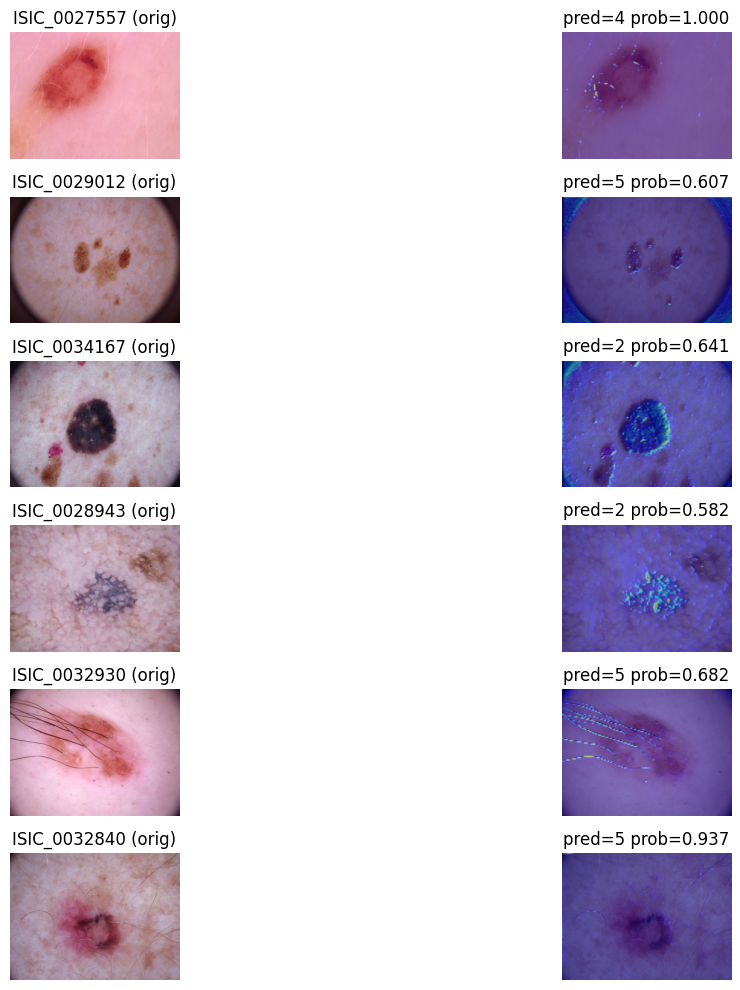

In [43]:
import matplotlib.pyplot as plt

target_layer = None
for name, module in model.named_modules():
    if name.endswith("conv_head") or name.endswith("conv_stem"):
        target_layer = module
        print("Using target layer:", name)
        break

# fallback: pick the last conv2d found
if target_layer is None:
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            print("Fallback target layer:", name)
            break

assert target_layer is not None, "Could not find a conv layer for GradCAM."

gc = SimpleGradCAM(model, target_layer)

#pick a few random test samples (image ids from test_df)
sample_ids = test_df['image_id'].sample(6, random_state=42).tolist()

plt.figure(figsize=(15,10))
for i, img_id in enumerate(sample_ids):
    #load original image (RGB uint8)
    img_path = os.path.join(IMG_PART_1_DIR, img_id + ".jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(IMG_PART_2_DIR, img_id + ".jpg")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    #Preprocess with val_transforms to get tensor
    inp = val_transforms(img_rgb)  # returns tensor
    input_tensor = inp.unsqueeze(0).to(device)

    # compute cam
    cam = gc(input_tensor)  # HxW normalized

    # overlay
    overlay = overlay_cam_on_image(img_rgb, cam, alpha=0.5)

    # plot: original, overlay, predicted probs
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(img_rgb)
    plt.title(f"{img_id} (orig)")
    plt.axis('off')

    plt.subplot(6, 2, 2*i+2)
    plt.imshow(overlay)
    # show predicted label and probs
    probs = softmax(model(input_tensor)).detach().cpu().numpy()[0]
    pred_label = int(probs.argmax())
    plt.title(f"pred={pred_label} prob={probs[pred_label]:.3f}")
    plt.axis('off')

plt.tight_layout()
gc.remove_hooks()